- VITOR GONÇALVES REIS DA SILVA RA: 156670
- MARCOS VINICIUS GASPAROTO BAUAB RA: 156717

# NOTAS IMPORTANTES

- Link para nossa base de dados https://www.kaggle.com/datasets/prosperchuks/amazonsatelliteimages
- Utilzamos apenas a pasta train-jpg e train_v2.csv
- O COLAB estava sofrendo para acessar os endereços das imagens de forma rápida sem bugar, então para rodar as 10.000 imagens é necessário baixar as pastas no seu computador

In [89]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import tensorflow_addons as tfa
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.applications.efficientnet import preprocess_input


In [90]:
import pandas as pd
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
import re
from sklearn.model_selection import KFold
import random
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from skimage.util import random_noise
import matplotlib.image as mpimg

In [91]:
data_labels = pd.read_csv(r"C:\Users\vitor\OneDrive\Área de Trabalho\train_v2.csv\train_v2.csv")
classes = data_labels['tags'].unique()
print("Quantidade de classes antes da normalização: ", len(classes))

Quantidade de classes antes da normalização:  449


In [92]:
data_labels.head(10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [93]:
# Estamos mapeando as classes, transformando todas as 449 em 2 floresta ou desmatado

def mapear_classes(tags):
    padrao = r"agriculture|mine|habitation|road" # Adicionei road também
    if re.search(padrao, tags):
        return 'desmatado'
    else:
        return 'floresta'

#estamos transformando todas as tags que aparecem cloudy em apenas cloudy para droparmos essas imagens pois são imagens que contém nuvens e não ajudam muito

def retirarImagensImprecisas(tags):
    padrao = r"cloudy|partly_cloudy"
    if re.search(padrao, tags):
        return 'cloudy'
    else:
        return tags

In [94]:
data_labels["tags"]=data_labels["tags"].apply(retirarImagensImprecisas)
data_labels = data_labels.drop(data_labels[data_labels['tags'] == 'cloudy'].index)  #dropando imagens com nuvem
data_labels["tags"]=data_labels["tags"].apply(mapear_classes) # Floresta ou desmatado
print(data_labels)

        image_name       tags
0          train_0   floresta
1          train_1  desmatado
2          train_2   floresta
3          train_3   floresta
4          train_4  desmatado
...            ...        ...
40472  train_40472  desmatado
40473  train_40473  desmatado
40474  train_40474   floresta
40476  train_40476  desmatado
40477  train_40477  desmatado

[31129 rows x 2 columns]


In [95]:
#data_labels= data_labels.drop(data_labels[data_labels['tags'] == 'floresta'].sample(n=6987, random_state=42).index)
class_counts = data_labels['tags'].value_counts()
print(class_counts)

tags
floresta     19058
desmatado    12071
Name: count, dtype: int64


In [96]:
classes = data_labels['tags'].unique()
print("Quantidade de classes depois da normalização: ", len(classes))

Quantidade de classes depois da normalização:  2


In [97]:
data_labels.head(11)

,image_name,tags
0,train_0,floresta
1,train_1,desmatado
2,train_2,floresta
3,train_3,floresta
4,train_4,desmatado
5,train_5,floresta
6,train_6,desmatado
7,train_7,floresta
8,train_8,desmatado
9,train_9,desmatado


In [98]:
# Definir parâmetros da rede neural
input_shape = (224, 224, 3) #tamanho original das imagens
new_size=(112,112,3) # redução pela metade
num_classes = 2

In [99]:
# Obter as classes e os nomes das imagens do arquivo CSV
# Aleatorização das imagens pegando do CSV o nome e a tag mas mantendo a ordenação

data_labels_aleatorio = data_labels.sample(n=5000, random_state=42)
classes = data_labels_aleatorio['tags'].tolist()
nomes_imagens= data_labels_aleatorio['image_name'].tolist()

In [100]:
data_labels_copia = data_labels.copy()
data_labels_copia = data_labels_copia.drop(data_labels_aleatorio.index) #DROPA PARA NÃO PEGAR IMAGENS IGUAIS
data_labels_segundo_aleatorio = data_labels_copia.sample(n=5000, random_state=42)   # CONJUNTO DE TESTE FINAL NUNCA ANTES VISTO PELO MODELO
classes_test = data_labels_segundo_aleatorio ['tags'].tolist()
nomes_imagens_test= data_labels_segundo_aleatorio ['image_name'].tolist()

Conjunto de teste para o estudante

In [101]:
X = []
y = []


# Diretório onde as imagens estão armazenadas
diretorio_imagens = r"C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg"
for classe, nome_imagem in zip(classes, nomes_imagens):
    caminho_imagem = os.path.join(diretorio_imagens, nome_imagem) + ".jpg"
    print("Caminho da imagem:", caminho_imagem)
    print("Classe:", classe)

    # Carregar as imagens e classes para treinamento
    imagem = load_img(caminho_imagem, target_size=new_size[:2])
    imagem_array = img_to_array(imagem)
    X.append(imagem_array)
    y.append(classe)



Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_5030.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_30807.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_23793.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_3850.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_10674.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_10907.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_21975.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_28843.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_14844.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\tra

Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_28078.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_20053.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_18144.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_15110.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_3444.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_34604.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_17916.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_10789.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_2478.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jp

Conjunto de teste para testar o professor no final


In [102]:
Xtest_E=[]
ytest_E=[]

for classe, nome_imagem in zip(classes_test, nomes_imagens_test):
    caminho_imagem = os.path.join(diretorio_imagens, nome_imagem) + ".jpg"
    print("Caminho da imagem:", caminho_imagem)
    print("Classe:", classe)

    # Carregar as imagens e classes para treinamento
    imagem = load_img(caminho_imagem, target_size=new_size[:2])
    imagem_array = img_to_array(imagem)
    Xtest_E.append(imagem_array)
    ytest_E.append(classe)

Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_33734.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_10212.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_17566.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_8259.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_37127.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_35831.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_13920.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_30632.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_39473.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\tr

In [103]:

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X = np.array(X) / 255.0
y = tf.keras.utils.to_categorical(y_encoded, num_classes)
y_encoded1=y_encoded

y_encoded = label_encoder.fit_transform(ytest_E)
Xtest_E= np.array(Xtest_E) / 255.0
ytest_E = tf.keras.utils.to_categorical(y_encoded, num_classes)



In [104]:
# Calcula a quantidade de amostras em cada classe
quantidade_classes = np.sum(ytest_E, axis=0)

# Exibe a quantidade de amostras em cada classe
for classe, quantidade in enumerate(quantidade_classes):
    print(f"Classe {classe}: {quantidade} amostras")

Classe 0: 1927.0 amostras
Classe 1: 3073.0 amostras


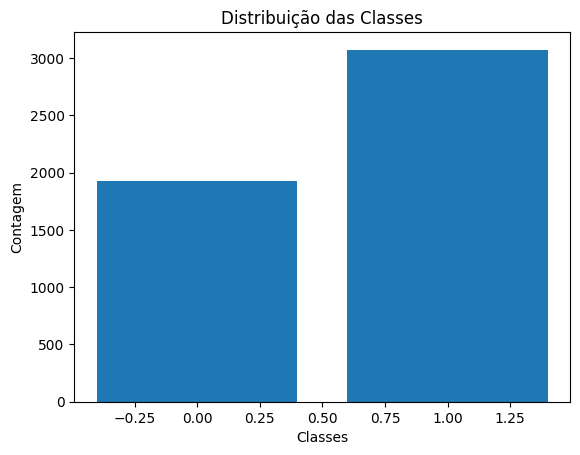

In [105]:

unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
plt.bar(unique_classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Contagem')
plt.title('Distribuição das Classes')
plt.show()

In [106]:
class MyModel(tf.keras.Model):
    def __init__(self, new_size, num_classes):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=new_size)
        self.maxpool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.dense2(x)
        return output


model_E = MyModel(new_size, num_classes)

model_E.compile(optimizer='adam', loss='categorical_crossentropy')


In [107]:
# Criar modelo da CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=new_size),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy')



Modelo Supervisionado treinado com todas as 1000 imagens sem Ruído, mesma estrutura


In [108]:
# Criar modelo da CNN
model_supervisioned = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=new_size),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilar o modelo
model_supervisioned.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


In [109]:
model_supervisioned.fit(X, y, epochs=10, batch_size=32) 

Epoch 1/10
157/157 [==============================] - 35s 207ms/step - loss: 0.5698 - accuracy: 0.7100
Epoch 2/10
157/157 [==============================] - 33s 213ms/step - loss: 0.4668 - accuracy: 0.7884
Epoch 3/10
157/157 [==============================] - 33s 210ms/step - loss: 0.4387 - accuracy: 0.8178
Epoch 4/10
157/157 [==============================] - 34s 219ms/step - loss: 0.4174 - accuracy: 0.8270
Epoch 5/10
157/157 [==============================] - 34s 214ms/step - loss: 0.3910 - accuracy: 0.8334
Epoch 6/10
157/157 [==============================] - 32s 205ms/step - loss: 0.3681 - accuracy: 0.8430
Epoch 7/10
157/157 [==============================] - 33s 210ms/step - loss: 0.3340 - accuracy: 0.8602
Epoch 8/10
157/157 [==============================] - 33s 211ms/step - loss: 0.2861 - accuracy: 0.8822
Epoch 9/10
157/157 [==============================] - 33s 212ms/step - loss: 0.2435 - accuracy: 0.9068
Epoch 10/10
157/157 [==============================] - 33s 213ms/step - l

# K Fold

- Para cada Fold são 4 conjuntos de teste, ou seja 80% dos dados, e 1 conjunto para treinamento, 20% dos dados. Eles são escolhidos de forma aleatória.

In [110]:
confusion_matrices = []
losses = []  # Array para armazenar as losses de cada fold estudante
losses_E= [] # Array para armazenar as losses de cada fold professor
balanced_accuracies = []


num_folds = 3  # Número desejado de folds

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(kf.split(X), 1):
    print("Fold", i)
    X_train, X_test = X[train_index], X[test_index] # O conjunto menor chamado de test será usado para treino 
    y_train, y_test = y[train_index], y[test_index]

    if (i > 1) :
      model = model_E
    
    history = model.fit(X_test, y_test, epochs=10, batch_size=32) #Treinamos o modelo com o conjunto teste 20%
    fold_losses = history.history['loss']
    losses.append(fold_losses)

    predictions = model.predict(X_train)
    X_test = np.concatenate((X_test, X_train))# SOMA O CONJUNTO DE IMAGENS DE TESTE COM PSEUDOLABELS + DE TREINO PARA CRIAR UM NOVO CONJUNTO DE TREINAMENTO 
    y_test = np.concatenate((y_test, predictions))
    noisy_images = []
    for image in X_test:
        noisy_image = random_noise(image, mode='speckle', var=0.03) # adicão de ruido ao conjunto de treinamento do estudante
        noisy_images.append(noisy_image)

    # Convertendo para um array numpy
    noisy_images = np.array(noisy_images)
    
    model_E = MyModel(new_size, num_classes)
    model_E.compile(optimizer='adam', loss='categorical_crossentropy')


    print("\nTREINAMENTO DO MODELO ESTUDANTE")
    history=model_E.fit(noisy_images,y_test, epochs=10, batch_size=32)# TREINA O MESMO MODELO PORÈM COM ESSE NOVO CONJUNTO DE TESTE 100% dos dados porém com os valores de Y == predição
    fold_losses= history.history['loss']
    losses_E.append(fold_losses)

    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_train, axis=1)
    confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
    confusion_matrices.append(confusion_matrix)
    predictions = model_E.predict(Xtest_E)
    predicted_classes = np.argmax(predictions, axis=1)
    balanced_accuracy = balanced_accuracy_score(y_encoded, predicted_classes)
    balanced_accuracies.append(balanced_accuracy)


    
    
    


Fold 1


Epoch 1/10
53/53 [==============================] - 12s 213ms/step - loss: 0.7134
Epoch 2/10
53/53 [==============================] - 10s 197ms/step - loss: 0.5703
Epoch 3/10
53/53 [==============================] - 10s 196ms/step - loss: 0.5236
Epoch 4/10
53/53 [==============================] - 10s 194ms/step - loss: 0.4899
Epoch 5/10
53/53 [==============================] - 11s 208ms/step - loss: 0.4669
Epoch 6/10
53/53 [==============================] - 11s 203ms/step - loss: 0.4765
Epoch 7/10
53/53 [==============================] - 10s 195ms/step - loss: 0.4215
Epoch 8/10
53/53 [==============================] - 10s 196ms/step - loss: 0.4113
Epoch 9/10
53/53 [==============================] - 10s 193ms/step - loss: 0.3906
Epoch 10/10
105/105 [==============================] - 5s 46ms/step

TREINAMENTO DO MODELO ESTUDANTE
Epoch 1/10
157/157 [==============================] - 36s 218ms/step - loss: 0.5868
Epoch 2/10
157/157 [==============================] - 33s 213ms/step - loss: 

In [111]:
#predictions_Efficient =model_EfficientNetB0.predict(Xtest_E)
#predicted_classes_Efficient=np.argmax(predictions_Efficient, axis=1)

predictions_supervisioned = model_supervisioned.predict(Xtest_E)

predicted_classes_supervisioned=np.argmax(predictions_supervisioned, axis=1)

Media_Acuracia_Balanceada=np.mean(balanced_accuracies)
desvio_padrao = np.std(balanced_accuracies)
balanced_accuracy = balanced_accuracy_score(y_encoded, predicted_classes_supervisioned)
#balanced_accuracy_Efficient=balanced_accuracy_score(y_encoded,predicted_classes_Efficient)


print("Desvio padrão:", desvio_padrao)
print(f"Média Acurácia Balanceada: {Media_Acuracia_Balanceada}")
#print(f"Acurácia Balanceada do modelo EfficientNETBO: {balanced_accuracy_Efficient}")
print(f"Acurácia Balanceada do modelo Supervisionado: {balanced_accuracy}")

157/157 [==============================] - 9s 53ms/step
Desvio padrão: 0.018306642597850968
Média Acurácia Balanceada: 0.7800097866519996
Acurácia Balanceada do modelo Supervisionado: 0.8431568555564806


MATRIZ DE CONFUSÃO DA PREDIÇÃO FEITA PELO MODELO ESTUDANTE VS A VERDADE DOS DADOS

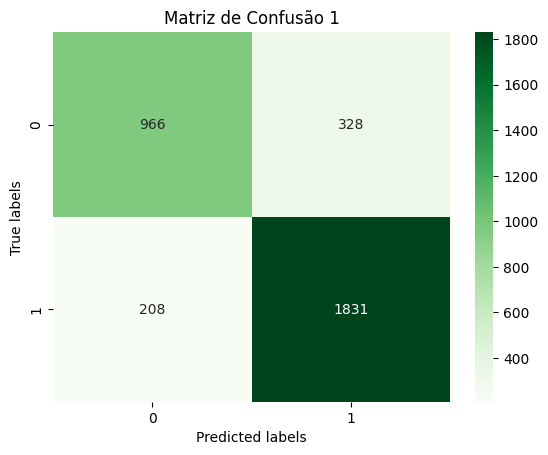

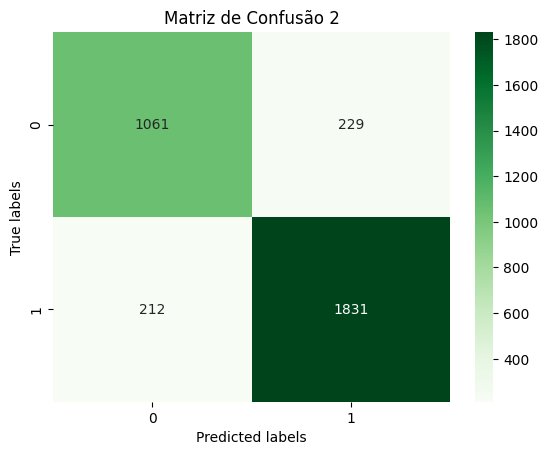

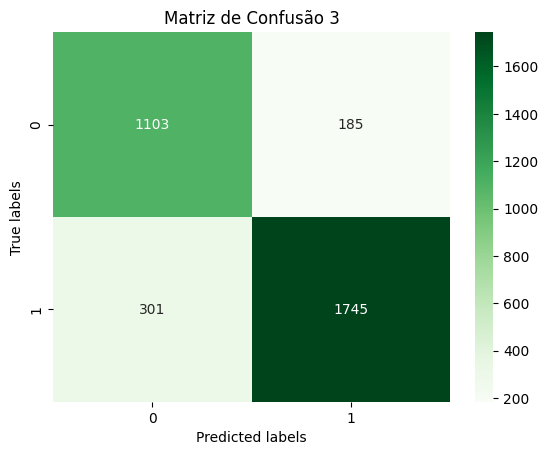

In [112]:
for i, matrix in enumerate(confusion_matrices):
    plt.figure()
    sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d')
    plt.title(f'Matriz de Confusão {i+1}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

LOSS DO CONJUNTO DE TREINAMENTO DOS MODELOS ESTUDANTE VS PROFESSOR


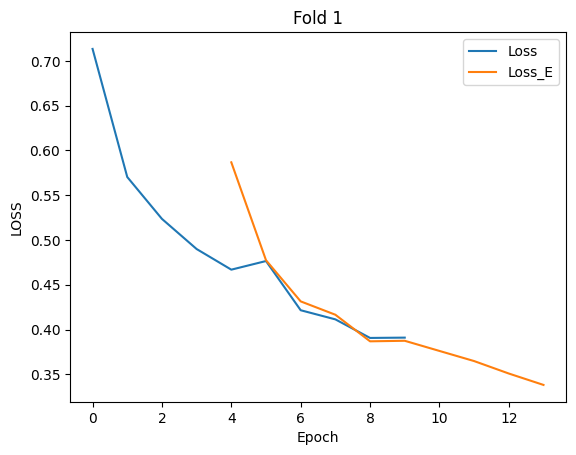

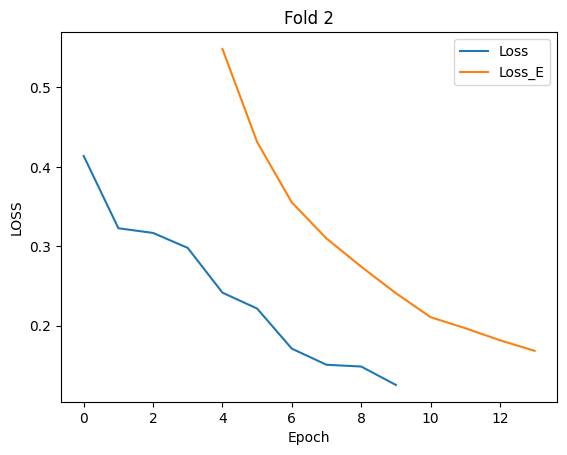

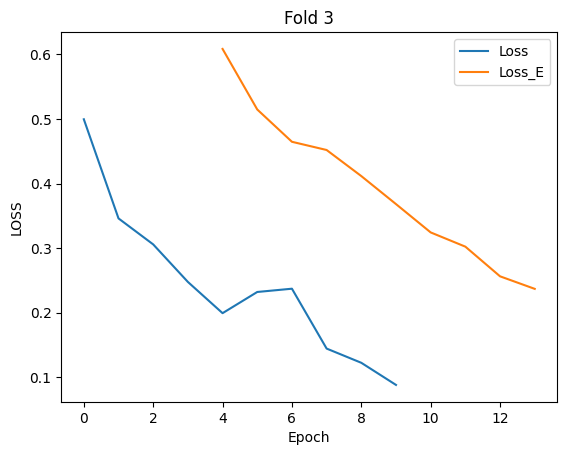

In [113]:
for i in range(num_folds):
    # Obtém as accuracies do fold atual
    fold_loss_E = losses_E[i]
    fold_loss = losses[i]

    # Plotar gráfico para o fold atual
    plt.figure()
    line_loss, = plt.plot(fold_loss, label='Loss')
    line_loss_E, = plt.plot(range(4, len(fold_loss_E)+4), fold_loss_E, label='Loss_E')  # A partir da epoch 4
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.title('Fold {}'.format(i + 1))
    plt.legend(handles=[line_loss, line_loss_E])
    plt.show()

MOSTRANDO UM POUCO DE COMO MEU MODELO ESTA PREVENDO OS VALORES NUNCA VISTOS E SUA ACURÁCIA BALANCEADA

In [114]:
predictions = model_E.predict(Xtest_E)

predicted_classes = np.argmax(predictions, axis=1)

for predicted_class, true_value in zip(predicted_classes, y_encoded):
    print(f"Previsão: {predicted_class}")
    print(f"Valor Real: {true_value}")
    print()

157/157 [==============================] - 8s 50ms/step
Previsão: 0
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 0
Valor Real: 0

Previsão: 0
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 0
Valor Real: 0

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1


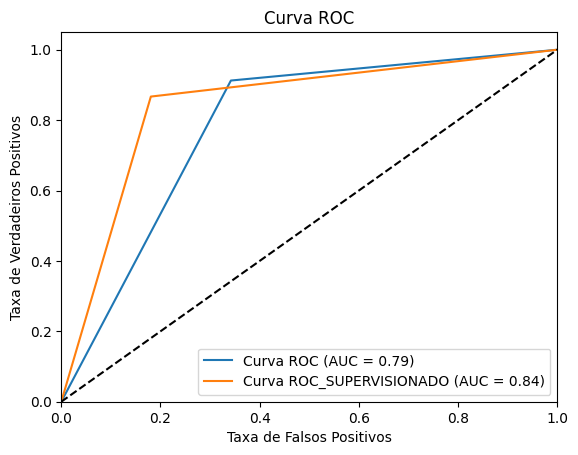

In [115]:
# Calcular os valores da curva ROC
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_encoded, predicted_classes)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_encoded, predicted_classes_supervisioned)

# Calcular a AUC
auc1=metrics.auc(fpr1,tpr1)
auc2=metrics.auc(fpr2,tpr2)

# Plotar a curva ROC
plt.plot(fpr1, tpr1, label='Curva ROC (AUC = %0.2f)' % auc1)
plt.plot(fpr2, tpr2, label='Curva ROC_SUPERVISIONADO (AUC = %0.2f)' % auc2)
plt.plot([0, 1], [0, 1], 'k--')  # Linha pontilhada representando a classificação aleatória
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

plt.show()

In [116]:
def calcular_entropia_imagem(imagem):
    # Converter o array NumPy em um objeto Image
    imagem_pil = Image.fromarray(imagem)

    # Converter a imagem para escala de cinza
    imagem_cinza = imagem_pil.convert('L')

    # Calcular o histograma da imagem
    histograma, _ = np.histogram(imagem_cinza, bins=256, range=(0, 255))

    # Normalizar o histograma
    probabilidade = histograma / np.sum(histograma)

    # Calcular a entropia
    entropia = -np.sum(probabilidade * np.log2(probabilidade + np.finfo(float).eps))

    return entropia


1/1 [==============================] - 0s 34ms/step
Previsão: 1
Valor Real: 1


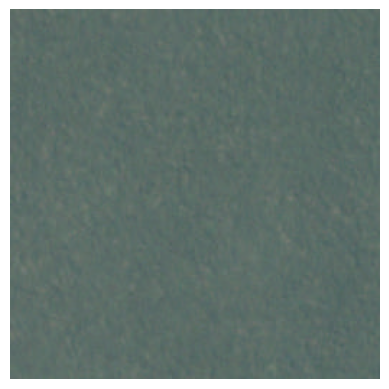

In [117]:
Caracteristicas=[]
Verdade=[]


caminho_imagem = diretorio_imagens +r"\train_0.jpg"

imagem = mpimg.imread(caminho_imagem)
imagem1 = load_img(caminho_imagem, target_size=new_size[:2])
imagem_array = img_to_array(imagem1)
Caracteristicas.append(imagem_array)
Verdade.append(1)
Caracteristicas = np.array(Caracteristicas) / 255.0
p=model.predict(Caracteristicas)
p_class = np.argmax(p, axis=1)
print(f"Previsão: {p_class[0]}")
print(f"Valor Real: {Verdade[0]}")





# Exibir a imagem
plt.imshow(imagem)
plt.axis('off')  # Remover os eixos
plt.show()

In [118]:
entropia = calcular_entropia_imagem(imagem)

print("Entropia da imagem:", entropia)

Entropia da imagem: 3.6725039194365334


1/1 [==============================] - 0s 31ms/step
Previsão: 0
Valor Real: 0


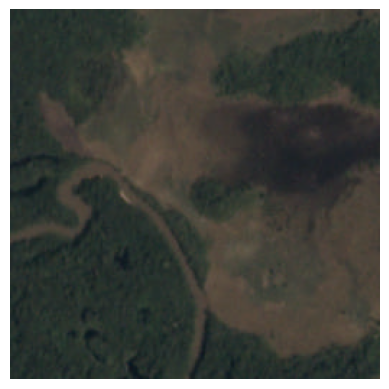

In [119]:
Caracteristicas=[]
Verdade=[]


caminho_imagem = diretorio_imagens +r"\train_10.jpg"

imagem = mpimg.imread(caminho_imagem)
imagem1 = load_img(caminho_imagem, target_size=new_size[:2])
imagem_array = img_to_array(imagem1)
Caracteristicas.append(imagem_array)
Verdade.append(0)
Caracteristicas = np.array(Caracteristicas) / 255.0
p=model.predict(Caracteristicas)
p_class = np.argmax(p, axis=1)
print(f"Previsão: {p_class[0]}")
print(f"Valor Real: {Verdade[0]}")





# Exibir a imagem
plt.imshow(imagem)
plt.axis('off')  # Remover os eixos
plt.show()

In [120]:
entropia = calcular_entropia_imagem(imagem)

print("Entropia da imagem:", entropia)

Entropia da imagem: 5.546395078154809


1/1 [==============================] - 0s 32ms/step
Previsão: 1
Valor Real: 1


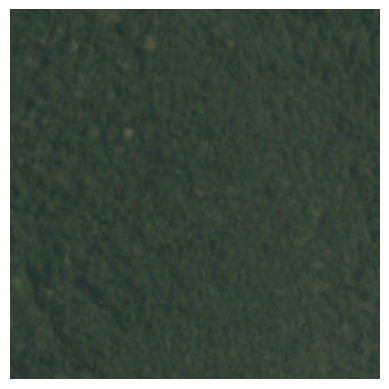

In [121]:
Caracteristicas=[]
Verdade=[]


caminho_imagem = diretorio_imagens +r"\train_3.jpg"

imagem = mpimg.imread(caminho_imagem)
imagem1 = load_img(caminho_imagem, target_size=new_size[:2])
imagem_array = img_to_array(imagem1)
Caracteristicas.append(imagem_array)
Verdade.append(1)
Caracteristicas = np.array(Caracteristicas) / 255.0
p=model.predict(Caracteristicas)
p_class = np.argmax(p, axis=1)
print(f"Previsão: {p_class[0]}")
print(f"Valor Real: {Verdade[0]}")





# Exibir a imagem
plt.imshow(imagem)
plt.axis('off')  # Remover os eixos
plt.show()

In [122]:
entropia = calcular_entropia_imagem(imagem)

print("Entropia da imagem:", entropia)

Entropia da imagem: 4.296034238939285


1/1 [==============================] - 0s 27ms/step
Previsão: 0
Valor Real: 0


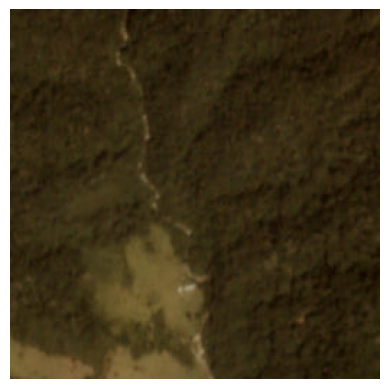

In [123]:
Caracteristicas=[]
Verdade=[]


caminho_imagem = diretorio_imagens +r"\train_4.jpg"

imagem = mpimg.imread(caminho_imagem)
imagem1 = load_img(caminho_imagem, target_size=new_size[:2])
imagem_array = img_to_array(imagem1)
Caracteristicas.append(imagem_array)
Verdade.append(0)
Caracteristicas = np.array(Caracteristicas) / 255.0
p=model.predict(Caracteristicas)
p_class = np.argmax(p, axis=1)
print(f"Previsão: {p_class[0]}")
print(f"Valor Real: {Verdade[0]}")





# Exibir a imagem
plt.imshow(imagem)
plt.axis('off')  # Remover os eixos
plt.show()

In [124]:
entropia = calcular_entropia_imagem(imagem)

print("Entropia da imagem:", entropia)

Entropia da imagem: 5.681677843404299


1/1 [==============================] - 0s 29ms/step
Previsão: 1
Valor Real: 1


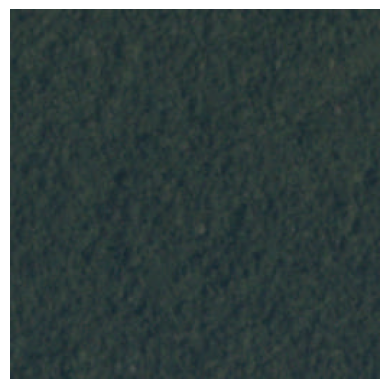

In [125]:
Caracteristicas=[]
Verdade=[]


caminho_imagem = diretorio_imagens +r"\train_2.jpg"

imagem = mpimg.imread(caminho_imagem)
imagem1 = load_img(caminho_imagem, target_size=new_size[:2])
imagem_array = img_to_array(imagem1)
Caracteristicas.append(imagem_array)
Verdade.append(1)
Caracteristicas = np.array(Caracteristicas) / 255.0
p=model.predict(Caracteristicas)
p_class = np.argmax(p, axis=1)
print(f"Previsão: {p_class[0]}")
print(f"Valor Real: {Verdade[0]}")





# Exibir a imagem
plt.imshow(imagem)
plt.axis('off')  # Remover os eixos
plt.show()

In [126]:
entropia = calcular_entropia_imagem(imagem)

print("Entropia da imagem:", entropia)

Entropia da imagem: 4.33182461991574
